In [0]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
import lightgbm as lgbm

In [2]:
# download dataset

%%shell
if ! [ -d "dataset" ]; then
  curl -L -o 'dataset.zip' 'https://docs.google.com/uc?export=download&id=1_F09b-A1xdAjOXKE7STqgiauSu4CnL1p'
  unzip dataset.zip
fi;

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    305      0 --:--:--  0:00:01 --:--:--   305
100 5510k    0 5510k    0     0   717k      0 --:--:--  0:00:07 --:--:--  887k
Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


In [0]:
data=pd.read_csv('dataset/train.csv')
data_np=np.array(data)
X=data_np[:,1:-1]
y_pre=data_np[:,-1]

In [4]:
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
device_name

b'Tesla T4'

In [16]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=b2d5d1ac27121d9f5fcd8de1e07c6a4f16664bac49966c743443547302e2a1e0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.4 GB  | Proc size: 2.1 GB
GPU RAM Free: 13274MB | Used: 1805MB | Util  12% | Total 15079MB


In [0]:
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_pre))
y=le.transform(y_pre)
#X=X.astype(float)
#X=np.log(X+1)

#X,y = sklearn.utils.shuffle(X,y,random_state=41)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=41)


In [17]:
#stacking ensemble xgb and lgbm

params_lgbm = {
    'objective': 'multiclass',
    #'metric': 'multi_logloss',
    #'is_unbalance': 'true',
    #'num_class':9,
    'n_estimators':625,
    'boosting_type': 'gbdt',
    'num_leaves': 110,
    'colsample_bytree': 0.5,
    'subsample': 0.8,
    'subsample_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0
}


#this is the same as the base xgboost
params_xgb = {
    'n_estimators': 520,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'max_depth': 9,
    'learning_rate': 0.05,
    'objective': 'multi:softprob', 
    'gamma': 1,
    'min_child_weight': 0.8,
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.8,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'random_state': 0
    }

params_fitter = {'n_estimators': 200,'max_depth':4, 'eta':0.05, 'objective':'multi:softprob', 'num_class': 9,'gamma': 3}


estimators = [('lgbm', lgbm.LGBMClassifier(**params_lgbm)),
               ('xgb', xgb.XGBClassifier(**params_xgb))]



reg = StackingClassifier(
     estimators=estimators,
     final_estimator=xgb.XGBClassifier(**params_fitter), verbose=2, stack_method = 'predict_proba')

reg.fit(X_train,y_train)
sklearn.metrics.log_loss(y_train, reg.predict_proba(X_train))
sklearn.metrics.log_loss(y_test, reg.predict_proba(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished


0.43382730814266435

# Everything below is shitcoding, don't look at it

In [6]:
parameters = {
    #'application': 'sigmoid',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'num_class':9,
    'boosting': 'gbdt',
    'num_leaves': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.87,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0,
    'device_type':'gpu'
}

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test)

model2 = lgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=200)

LightGBMError: ignored

0.5368180511913354

In [10]:
params = {
    'objective': 'multiclass',
    #'metric': 'multi_logloss',
    #'is_unbalance': 'true',
    #'num_class':9,
    'n_estimators':2000,
    'boosting_type': 'gbdt',
    'num_leaves': 110,
    'colsample_bytree': 0.5,
    'subsample': 0.8,
    'subsample_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0
}


fit_param = {
    'eval_set': [(X_test, y_test)],
    'eval_metric': 'multi_logloss',
    'verbose': True,
    'early_stopping_rounds': 100
}

#set number of rounds

clf_lgbm = lgbm.LGBMClassifier(**params).fit(X_train, y_train,**fit_param)
#print('Train set error ',sklearn.metrics.log_loss(y_train, clf_lgbm.predict_proba(X_train)))
sklearn.metrics.log_loss(y_test,clf_lgbm.predict_proba(X_test))

[1]	valid_0's multi_logloss: 1.89763	valid_0's multi_logloss: 1.89763
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.84647	valid_0's multi_logloss: 1.84647
[3]	valid_0's multi_logloss: 1.79964	valid_0's multi_logloss: 1.79964
[4]	valid_0's multi_logloss: 1.75322	valid_0's multi_logloss: 1.75322
[5]	valid_0's multi_logloss: 1.71578	valid_0's multi_logloss: 1.71578
[6]	valid_0's multi_logloss: 1.67915	valid_0's multi_logloss: 1.67915
[7]	valid_0's multi_logloss: 1.64594	valid_0's multi_logloss: 1.64594
[8]	valid_0's multi_logloss: 1.60892	valid_0's multi_logloss: 1.60892
[9]	valid_0's multi_logloss: 1.5754	valid_0's multi_logloss: 1.5754
[10]	valid_0's multi_logloss: 1.54412	valid_0's multi_logloss: 1.54412
[11]	valid_0's multi_logloss: 1.51327	valid_0's multi_logloss: 1.51327
[12]	valid_0's multi_logloss: 1.48575	valid_0's multi_logloss: 1.48575
[13]	valid_0's multi_logloss: 1.45937	valid_0's multi_logloss: 1.45937
[14]	valid_0's multi_logl

0.44037842616665457

In [25]:
parameters = {
    #'application': 'sigmoid',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'num_class':9,
    'boosting': 'gbdt',
    'num_leaves': 110,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0
}

model2 = lgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=70)

[1]	valid_0's multi_logloss: 1.89729
Training until validation scores don't improve for 70 rounds.
[2]	valid_0's multi_logloss: 1.84587
[3]	valid_0's multi_logloss: 1.79898
[4]	valid_0's multi_logloss: 1.75286
[5]	valid_0's multi_logloss: 1.71525
[6]	valid_0's multi_logloss: 1.67858
[7]	valid_0's multi_logloss: 1.64506
[8]	valid_0's multi_logloss: 1.60802
[9]	valid_0's multi_logloss: 1.57424
[10]	valid_0's multi_logloss: 1.54321
[11]	valid_0's multi_logloss: 1.51222
[12]	valid_0's multi_logloss: 1.48486
[13]	valid_0's multi_logloss: 1.45842
[14]	valid_0's multi_logloss: 1.43403
[15]	valid_0's multi_logloss: 1.40835
[16]	valid_0's multi_logloss: 1.38576
[17]	valid_0's multi_logloss: 1.36452
[18]	valid_0's multi_logloss: 1.34413
[19]	valid_0's multi_logloss: 1.32242
[20]	valid_0's multi_logloss: 1.30097
[21]	valid_0's multi_logloss: 1.28251
[22]	valid_0's multi_logloss: 1.26297
[23]	valid_0's multi_logloss: 1.2454
[24]	valid_0's multi_logloss: 1.22789
[25]	valid_0's multi_logloss: 1.2102

In [0]:
4416
4403

In [0]:
####!!!!THIS GIVES ERROR OF 0.4403

dtrain1=xgb.DMatrix(X_train,label=y_train)
dtest1=xgb.DMatrix(X_test,label=y_test)

param = {'max_depth':9, 'eta':0.01, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, }
#num_round = 200
#bst = xgb.train(param, dtrain1, num_round)


bst = xgb.train(param, dtrain1, 400)
xgb4_pred_test = bst.predict(dtest1)
xgb4_pred_train = bst.predict(dtrain1)

print(sklearn.metrics.log_loss(y_train, bst.predict(dtrain1)))
print(sklearn.metrics.log_loss(y_test, bst.predict(dtest1)))

In [8]:
listy=[]
for i in range(X_train.shape[0]):
  listy.append(93-len(np.nonzero(X_train[i,:])[0]))
   #listy.append(sum([1 for x in X_train[i,:] if X_train[i,x]==0]))
extra_feat=np.array(listy).reshape(-1,1)
X_train1=np.hstack((X_train,extra_feat))

listy=[]
for i in range(X_test.shape[0]):
  listy.append(93-len(np.nonzero(X_test[i,:])[0]))
   #listy.append(sum([1 for x in X_train[i,:] if X_train[i,x]==0]))
extra_feat=np.array(listy).reshape(-1,1)
X_test1=np.hstack((X_test,extra_feat))
#a=[0,2,3,0,5]
#np.nonzero(a)[0]
'''
clust = KMeans(2).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(4).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(8).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(16).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(32).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(64).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))

clust = KMeans(128).fit(X_train1)
X_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))
X_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))


scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train1)
X_train1=scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)
'''
#X_train1[X_train1==0]='NA'

'\nclust = KMeans(2).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n\nclust = KMeans(4).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n\nclust = KMeans(8).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n\nclust = KMeans(16).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n\nclust = KMeans(32).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n\nclust = KMeans(64).fit(X_train1)\nX_train1 = np.hstack((X_train1,clust.labels_.reshape(-1,1)))\nX_test1 = np.hstack((X_test1,clust.predict(X_test1).reshape(-1,1)))\n

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train1,y_train)

In [14]:
dtrain1=xgb.DMatrix(X_train1,label=y_train)
dtest1=xgb.DMatrix(X_test1,label=y_test)

param = {'max_depth':9, 'eta':0.05, 'objective':'multi:softprob', 'eval_metric':'mlogloss','eval_set':'dtest1', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, 'tree_method':'gpu_hist'}
num_round = 1200
#bst = xgb.train(param, dtrain1, num_round)


bst = xgb.train(param, dtrain1, num_round,early_stopping_rounds=100, verbose_eval=True, evals=[(dtest1,'test')])
xgb4_pred_test = bst.predict(dtest1)
xgb4_pred_train = bst.predict(dtrain1)

print(sklearn.metrics.log_loss(y_train, bst.predict(dtrain1)))
print(sklearn.metrics.log_loss(y_test, bst.predict(dtest1)))

[0]	test-mlogloss:2.0721
Will train until test-mlogloss hasn't improved in 100 rounds.
[1]	test-mlogloss:1.96513
[2]	test-mlogloss:1.87334
[3]	test-mlogloss:1.79114
[4]	test-mlogloss:1.72117
[5]	test-mlogloss:1.65854
[6]	test-mlogloss:1.59826
[7]	test-mlogloss:1.54376
[8]	test-mlogloss:1.49326
[9]	test-mlogloss:1.44732
[10]	test-mlogloss:1.40306
[11]	test-mlogloss:1.36308
[12]	test-mlogloss:1.32526
[13]	test-mlogloss:1.28984
[14]	test-mlogloss:1.25585
[15]	test-mlogloss:1.22464
[16]	test-mlogloss:1.19472
[17]	test-mlogloss:1.16645
[18]	test-mlogloss:1.13949
[19]	test-mlogloss:1.11446
[20]	test-mlogloss:1.09088
[21]	test-mlogloss:1.06854
[22]	test-mlogloss:1.04736
[23]	test-mlogloss:1.02625
[24]	test-mlogloss:1.0069
[25]	test-mlogloss:0.987873
[26]	test-mlogloss:0.969977
[27]	test-mlogloss:0.953089
[28]	test-mlogloss:0.937151
[29]	test-mlogloss:0.922031
[30]	test-mlogloss:0.907817
[31]	test-mlogloss:0.893379
[32]	test-mlogloss:0.880251
[33]	test-mlogloss:0.867226
[34]	test-mlogloss:0.85

In [0]:
4431

In [12]:
#this is the same as the base xgboost
param = {
    'n_estimators': 1200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'max_depth': 9,
    'learning_rate': 0.05,
    'objective': 'multi:softprob', 
    'gamma': 1,
    'min_child_weight': 0.8,
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.8,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'random_state': 0
    }

fit_param = {
    'eval_set': [(X_test1, y_test)],
    'eval_metric': 'mlogloss',
    'verbose': True,
    'early_stopping_rounds': 100
}

model = xgb.XGBClassifier(**param)
model.fit(X_train1,y_train,**fit_param)

[0]	validation_0-mlogloss:2.0721
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.96513
[2]	validation_0-mlogloss:1.87334
[3]	validation_0-mlogloss:1.79114
[4]	validation_0-mlogloss:1.72117
[5]	validation_0-mlogloss:1.65854
[6]	validation_0-mlogloss:1.59826
[7]	validation_0-mlogloss:1.54376
[8]	validation_0-mlogloss:1.49326
[9]	validation_0-mlogloss:1.44732
[10]	validation_0-mlogloss:1.40306
[11]	validation_0-mlogloss:1.36308
[12]	validation_0-mlogloss:1.32526
[13]	validation_0-mlogloss:1.28984
[14]	validation_0-mlogloss:1.25585
[15]	validation_0-mlogloss:1.22464
[16]	validation_0-mlogloss:1.19472
[17]	validation_0-mlogloss:1.16645
[18]	validation_0-mlogloss:1.13949
[19]	validation_0-mlogloss:1.11446
[20]	validation_0-mlogloss:1.09088
[21]	validation_0-mlogloss:1.06854
[22]	validation_0-mlogloss:1.04736
[23]	validation_0-mlogloss:1.02625
[24]	validation_0-mlogloss:1.0069
[25]	validation_0-mlogloss:0.987873
[26]	validation_0-mlogloss:0.96

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=0.8, missing=None, n_estimators=1200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [0]:
param = {
    'n_estimators': 800,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'learning_rate': 0.05,
    'max_depth': 8,
    'objective': 'multi:softprob', 
    'gamma': 1,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
  #  'random_state': 2
    }


bag = BaggingClassifier(base_estimator = xgb.XGBClassifier(**param), n_estimators=20, random_state=0, verbose=2)
bag.fit(X_train,y_train)
sklearn.metrics.log_loss(y_test, bag.predict_proba(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...


In [0]:
448

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=d4c280adb8403b4eecaea22d2eeaa17f771d7e7b99f97e26c22d247cdb1e8510
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [0]:
sklearn.metrics.log_loss(y_test,bag.predict_proba(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


0.44850546942635977

In [0]:
param = {
    'n_estimators': 1200,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'learning_rate': 0.05,
    'max_depth': 8,
    'objective': 'multi:softprob', 
    'gamma': 1,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'random_state': 2
    }

fit_param = {
    'eval_set': [(X_test, y_test)],
    'eval_metric': 'mlogloss',
    'verbose': True,
    'early_stopping_rounds': 100
}

model2 = xgb.XGBClassifier(**param)
model2.fit(X_train,y_train,**fit_param)

[0]	validation_0-mlogloss:2.07614
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.97843
[2]	validation_0-mlogloss:1.88747
[3]	validation_0-mlogloss:1.80984
[4]	validation_0-mlogloss:1.73819
[5]	validation_0-mlogloss:1.67287
[6]	validation_0-mlogloss:1.61335
[7]	validation_0-mlogloss:1.56289
[8]	validation_0-mlogloss:1.51418
[9]	validation_0-mlogloss:1.46777
[10]	validation_0-mlogloss:1.42455
[11]	validation_0-mlogloss:1.38391
[12]	validation_0-mlogloss:1.34589
[13]	validation_0-mlogloss:1.31022
[14]	validation_0-mlogloss:1.27688
[15]	validation_0-mlogloss:1.24661
[16]	validation_0-mlogloss:1.21681
[17]	validation_0-mlogloss:1.18832
[18]	validation_0-mlogloss:1.16318
[19]	validation_0-mlogloss:1.13843
[20]	validation_0-mlogloss:1.11449
[21]	validation_0-mlogloss:1.09194
[22]	validation_0-mlogloss:1.07034
[23]	validation_0-mlogloss:1.0498
[24]	validation_0-mlogloss:1.03115
[25]	validation_0-mlogloss:1.01244
[26]	validation_0-mlogloss:0.99

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [0]:
#K-fold cross validation split
kf = KFold(5,shuffle=False)
kf.get_n_splits(X)

list_prob=[]
for train_index,test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf_lgbm = lgbm.LGBMClassifier(num_leaves=50).fit(X_train, y_train)
    print('Train set error ',sklearn.metrics.log_loss(y_train, clf_lgbm.predict_proba(X_train)))
    log_loss = sklearn.metrics.log_loss(y_test,clf_lgbm.predict_proba(X_test))
    print('Test set error',log_loss)
    list_prob.append(log_loss)
print(np.mean(list_prob))
    

Train set error  0.3348640453488358
Test set error 0.48309175226798884
Train set error  0.3304082128901749
Test set error 0.5092631439123212
Train set error  0.3328139436770707
Test set error 0.4952716977160145
Train set error  0.3323229740387447
Test set error 0.4929220248768979
Train set error  0.3331325171788779
Test set error 0.49874807769656404
0.4958593392939573


(array([ 1530., 12944.,  6443.,  2153.,     0.,  2174., 11251.,  2287.,
         6790.,  3930.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

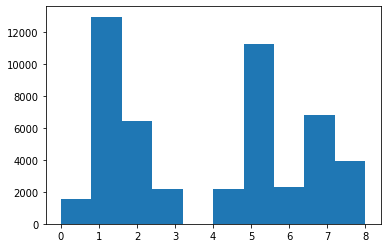

In [0]:
plt.hist(y_train)

# Random forest

In [0]:
clf = RandomForestClassifier(max_depth=10, random_state=2)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

/Users/petar.hristov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7678571428571429

In [0]:
clf.predict_proba(X_test)

array([[0.06490965, 0.25501547, 0.14907195, ..., 0.08376932, 0.06689077,
        0.04719386],
       [0.0268758 , 0.14162775, 0.05081799, ..., 0.4892125 , 0.13190942,
        0.10729225],
       [0.02533418, 0.01191287, 0.00804023, ..., 0.01963451, 0.02207811,
        0.01915134],
       ...,
       [0.3       , 0.        , 0.        , ..., 0.        , 0.1       ,
        0.525     ],
       [0.00633374, 0.73957007, 0.1678721 , ..., 0.00810614, 0.0087625 ,
        0.00909745],
       [0.01575013, 0.03273587, 0.01683241, ..., 0.50297848, 0.29587521,
        0.01574389]])

In [0]:
sklearn.metrics.log_loss(y_test, clf.predict_proba(X_test))

0.7396735462971555

# Logistic regression

In [0]:
clf_logistic = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train,y_train)
logistic_accuracy = clf_logistic.score(X_test,y_test)
logistic_log_loss = sklearn.metrics.log_loss(y_test, clf_logistic.predict_proba(X_test))
print('Logloss is ',logistic_log_loss)

Logloss is  1.9613119317289052


/Users/petar.hristov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# KNN

In [0]:
clf_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)
knn_accuracy = clf_knn.score(X_test,y_test)
knn_log_loss = sklearn.metrics.log_loss(y_test, clf_knn.predict_proba(X_test))
print('Logloss is ',knn_log_loss)

Logloss is  2.3086776076579794


In [0]:
knn_accuracy

0.7807045895281189

# SVM Linear

In [0]:
clf_svm = sklearn.svm.SVC(probability=True,kernel='linear').fit(X_train,y_train)
svm_accuracy = clf_svm.score(X_test,y_test)
svm_log_loss = sklearn.metrics.log_loss(y_test, clf_svm.predict_proba(X_test))

In [0]:
sklearn.metrics.log_loss(y_test, clf_svm.predict_proba(X_test))

# SVM Radial

# XGBoost

In [0]:
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test,label=y_test)

In [0]:
param = {'max_depth':8, 'eta':1, 'objective':'multi:softprob', 'num_class': 9}
num_round = 40
bst = xgb.train(param, dtrain, num_round)
#sklearn.metrics.accuracy_score(y_test,bst.predict(dtest))
sklearn.metrics.log_loss(y_test, bst.predict(dtest))

0.569466574998273

# Stack Different Models

Try out first with logistic, random forest and XGboost.

In [0]:
#this time split data in 3 chunks - train, stack train, test (60%, 20%, 20%)
data=pd.read_csv('train.csv')
data_np=np.array(data)
X=data_np[:,1:-1]
y_pre=data_np[:,-1]

le = preprocessing.LabelEncoder()
le.fit(np.unique(y_pre))
y=le.transform(y_pre)

#get the first split
X_temp, X_test, y_temp, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=41)

X_train, X_stack, y_train, y_stack = sklearn.model_selection.train_test_split(X_temp,y_temp, test_size=0.25, random_state=41)

Get some models trained on the train set and then make predictions both for stack and test set

In [0]:
clf_logistic = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train,y_train)
logistic_pred_test = clf_logistic.predict(X_test)
logistic_pred_stack = clf_logistic.predict(X_stack)
logistic_log_loss = sklearn.metrics.log_loss(y_test, clf_logistic.predict_proba(X_test))
print('Logistic logloss is ',logistic_log_loss)

Logistic logloss is  0.631577644078975


/Users/petar.hristov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
644

In [0]:
clf_rf = RandomForestClassifier(max_depth=20, random_state=2, n_estimators=200)
clf_rf.fit(X_train, y_train)
rf_pred_test = clf_rf.predict(X_test)
rf_pred_stack = clf_rf.predict(X_stack)
rf_log_loss = sklearn.metrics.log_loss(y_test, clf_rf.predict_proba(X_test))
print('Random forest logloss is ', rf_log_loss)


Random forest logloss is  0.6672842405993349


In [0]:
6711

In [0]:
dtrain=xgb.DMatrix(X_train,label=y_train)
dstack=xgb.DMatrix(X_stack,label=y_stack)
dtest=xgb.DMatrix(X_test,label=y_test)
param = {'max_depth':8, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9}
num_round = 80
bst = xgb.train(param, dtrain, num_round)
xgb_pred_test = bst.predict(dtest)
xgb_pred_stack = bst.predict(dstack)
sklearn.metrics.log_loss(y_test, bst.predict(dtest))

NameError: name 'X_stack' is not defined

In [0]:
5343

In [0]:
param = {'max_depth':4, 'eta':1, 'objective':'multi:softprob', 'num_class': 9}
bst2 = xgb.train(param, dtrain, num_round)
xgb2_pred_test = bst2.predict(dtest)
xgb2_pred_stack = bst2.predict(dstack)
sklearn.metrics.log_loss(y_test, bst2.predict(dtest))

NameError: name 'dtrain' is not defined

In [0]:
5545

In [0]:
param = {'max_depth':12, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9}
bst3 = xgb.train(param, dtrain, num_round)
xgb3_pred_test = bst3.predict(dtest)
xgb3_pred_stack = bst3.predict(dstack)
sklearn.metrics.log_loss(y_test, bst3.predict(dtest))

0.49655430405301737

In [0]:
5069

In [0]:
param = {'max_depth':9, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, }
bst4 = xgb.train(param, dtrain, 400)
xgb4_pred_test = bst4.predict(dtest)
xgb4_pred_stack = bst4.predict(dstack)
print('Train set error ',sklearn.metrics.log_loss(y_train, bst4.predict(dtrain)))
print('Test set error ',sklearn.metrics.log_loss(y_test, bst4.predict(dtest)))

Train set error  0.17525186159464382
Test set error  0.4591945110461338


In [0]:
4694

In [0]:
#LightGBM
clf_lgbm = lgbm.LGBMClassifier(num_leaves=50).fit(X_train, y_train)
print('Train set error ',sklearn.metrics.log_loss(y_train, clf_lgbm.predict_proba(X_train)))
sklearn.metrics.log_loss(y_test,clf_lgbm.predict_proba(X_test))

Train set error  0.30539586550667924


0.4912138850186399

In [0]:
4972

In [0]:
clf_lgbm2 = lgbm.LGBMClassifier(num_leaves=70).fit(X_train, y_train)
sklearn.metrics.log_loss(y_test,clf_lgbm2.predict_proba(X_test))

0.4830322590837645

In [0]:
487

In [0]:
#LightGBM
clf_lgbm3 = lgbm.LGBMClassifier(num_leaves=100).fit(X_train, y_train)
sklearn.metrics.log_loss(y_test,clf_lgbm3.predict_proba(X_test))

0.47636401218787144

In [0]:
4831

In [0]:
parameters = {
    #'application': 'sigmoid',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'num_class':9,
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0
}

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test)

model2 = lgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=200)

[1]	valid_0's multi_logloss: 1.90127
Training until validation scores don't improve for 200 rounds
[2]	valid_0's multi_logloss: 1.85721
[3]	valid_0's multi_logloss: 1.81647
[4]	valid_0's multi_logloss: 1.77461
[5]	valid_0's multi_logloss: 1.74133
[6]	valid_0's multi_logloss: 1.70868
[7]	valid_0's multi_logloss: 1.67894
[8]	valid_0's multi_logloss: 1.64423
[9]	valid_0's multi_logloss: 1.6139
[10]	valid_0's multi_logloss: 1.58606
[11]	valid_0's multi_logloss: 1.55783
[12]	valid_0's multi_logloss: 1.53241
[13]	valid_0's multi_logloss: 1.5083
[14]	valid_0's multi_logloss: 1.48502
[15]	valid_0's multi_logloss: 1.46146
[16]	valid_0's multi_logloss: 1.44044
[17]	valid_0's multi_logloss: 1.42144
[18]	valid_0's multi_logloss: 1.40241
[19]	valid_0's multi_logloss: 1.38233
[20]	valid_0's multi_logloss: 1.36184
[21]	valid_0's multi_logloss: 1.3444
[22]	valid_0's multi_logloss: 1.32594
[23]	valid_0's multi_logloss: 1.30897
[24]	valid_0's multi_logloss: 1.29226
[25]	valid_0's multi_logloss: 1.27543


[209]	valid_0's multi_logloss: 0.568855
[210]	valid_0's multi_logloss: 0.568119
[211]	valid_0's multi_logloss: 0.567399
[212]	valid_0's multi_logloss: 0.566711
[213]	valid_0's multi_logloss: 0.566121
[214]	valid_0's multi_logloss: 0.565447
[215]	valid_0's multi_logloss: 0.564726
[216]	valid_0's multi_logloss: 0.564043
[217]	valid_0's multi_logloss: 0.563399
[218]	valid_0's multi_logloss: 0.56275
[219]	valid_0's multi_logloss: 0.562027
[220]	valid_0's multi_logloss: 0.561457
[221]	valid_0's multi_logloss: 0.560781
[222]	valid_0's multi_logloss: 0.560191
[223]	valid_0's multi_logloss: 0.559549
[224]	valid_0's multi_logloss: 0.558879
[225]	valid_0's multi_logloss: 0.558233
[226]	valid_0's multi_logloss: 0.557555
[227]	valid_0's multi_logloss: 0.556841
[228]	valid_0's multi_logloss: 0.556165
[229]	valid_0's multi_logloss: 0.555555
[230]	valid_0's multi_logloss: 0.554944
[231]	valid_0's multi_logloss: 0.55439
[232]	valid_0's multi_logloss: 0.553785
[233]	valid_0's multi_logloss: 0.553208
[2

[415]	valid_0's multi_logloss: 0.496748
[416]	valid_0's multi_logloss: 0.496586
[417]	valid_0's multi_logloss: 0.496511
[418]	valid_0's multi_logloss: 0.496369
[419]	valid_0's multi_logloss: 0.4962
[420]	valid_0's multi_logloss: 0.496016
[421]	valid_0's multi_logloss: 0.49584
[422]	valid_0's multi_logloss: 0.495705
[423]	valid_0's multi_logloss: 0.495539
[424]	valid_0's multi_logloss: 0.495429
[425]	valid_0's multi_logloss: 0.495269
[426]	valid_0's multi_logloss: 0.495094
[427]	valid_0's multi_logloss: 0.494923
[428]	valid_0's multi_logloss: 0.49478
[429]	valid_0's multi_logloss: 0.49466
[430]	valid_0's multi_logloss: 0.494558
[431]	valid_0's multi_logloss: 0.494434
[432]	valid_0's multi_logloss: 0.494273
[433]	valid_0's multi_logloss: 0.494145
[434]	valid_0's multi_logloss: 0.493949
[435]	valid_0's multi_logloss: 0.493793
[436]	valid_0's multi_logloss: 0.493689
[437]	valid_0's multi_logloss: 0.493547
[438]	valid_0's multi_logloss: 0.493425
[439]	valid_0's multi_logloss: 0.493286
[440]

[623]	valid_0's multi_logloss: 0.474939
[624]	valid_0's multi_logloss: 0.474887
[625]	valid_0's multi_logloss: 0.474839
[626]	valid_0's multi_logloss: 0.474733
[627]	valid_0's multi_logloss: 0.474686
[628]	valid_0's multi_logloss: 0.474605
[629]	valid_0's multi_logloss: 0.474531
[630]	valid_0's multi_logloss: 0.474475
[631]	valid_0's multi_logloss: 0.47444
[632]	valid_0's multi_logloss: 0.474393
[633]	valid_0's multi_logloss: 0.474318
[634]	valid_0's multi_logloss: 0.474229
[635]	valid_0's multi_logloss: 0.474179
[636]	valid_0's multi_logloss: 0.474102
[637]	valid_0's multi_logloss: 0.474079
[638]	valid_0's multi_logloss: 0.474059
[639]	valid_0's multi_logloss: 0.473999
[640]	valid_0's multi_logloss: 0.473968
[641]	valid_0's multi_logloss: 0.473912
[642]	valid_0's multi_logloss: 0.473867
[643]	valid_0's multi_logloss: 0.473806
[644]	valid_0's multi_logloss: 0.473799
[645]	valid_0's multi_logloss: 0.473743
[646]	valid_0's multi_logloss: 0.473723
[647]	valid_0's multi_logloss: 0.473631
[

[830]	valid_0's multi_logloss: 0.465217
[831]	valid_0's multi_logloss: 0.465233
[832]	valid_0's multi_logloss: 0.465216
[833]	valid_0's multi_logloss: 0.465178
[834]	valid_0's multi_logloss: 0.465149
[835]	valid_0's multi_logloss: 0.465137
[836]	valid_0's multi_logloss: 0.465123
[837]	valid_0's multi_logloss: 0.465101
[838]	valid_0's multi_logloss: 0.46508
[839]	valid_0's multi_logloss: 0.465045
[840]	valid_0's multi_logloss: 0.46505
[841]	valid_0's multi_logloss: 0.464974
[842]	valid_0's multi_logloss: 0.464934
[843]	valid_0's multi_logloss: 0.46494
[844]	valid_0's multi_logloss: 0.464939
[845]	valid_0's multi_logloss: 0.464925
[846]	valid_0's multi_logloss: 0.464902
[847]	valid_0's multi_logloss: 0.464858
[848]	valid_0's multi_logloss: 0.464812
[849]	valid_0's multi_logloss: 0.464783
[850]	valid_0's multi_logloss: 0.464773
[851]	valid_0's multi_logloss: 0.464768
[852]	valid_0's multi_logloss: 0.464714
[853]	valid_0's multi_logloss: 0.464703
[854]	valid_0's multi_logloss: 0.464679
[85

[1038]	valid_0's multi_logloss: 0.461542
[1039]	valid_0's multi_logloss: 0.461526
[1040]	valid_0's multi_logloss: 0.461504
[1041]	valid_0's multi_logloss: 0.461504
[1042]	valid_0's multi_logloss: 0.461477
[1043]	valid_0's multi_logloss: 0.461483
[1044]	valid_0's multi_logloss: 0.461457
[1045]	valid_0's multi_logloss: 0.46141
[1046]	valid_0's multi_logloss: 0.461388
[1047]	valid_0's multi_logloss: 0.461389
[1048]	valid_0's multi_logloss: 0.46139
[1049]	valid_0's multi_logloss: 0.461382
[1050]	valid_0's multi_logloss: 0.461396
[1051]	valid_0's multi_logloss: 0.461333
[1052]	valid_0's multi_logloss: 0.461279
[1053]	valid_0's multi_logloss: 0.461265
[1054]	valid_0's multi_logloss: 0.461224
[1055]	valid_0's multi_logloss: 0.461184
[1056]	valid_0's multi_logloss: 0.461171
[1057]	valid_0's multi_logloss: 0.461172
[1058]	valid_0's multi_logloss: 0.461174
[1059]	valid_0's multi_logloss: 0.461125
[1060]	valid_0's multi_logloss: 0.461142
[1061]	valid_0's multi_logloss: 0.461124
[1062]	valid_0's m

[1242]	valid_0's multi_logloss: 0.459997
[1243]	valid_0's multi_logloss: 0.460017
[1244]	valid_0's multi_logloss: 0.460035
[1245]	valid_0's multi_logloss: 0.460075
[1246]	valid_0's multi_logloss: 0.460091
[1247]	valid_0's multi_logloss: 0.4601
[1248]	valid_0's multi_logloss: 0.460105
[1249]	valid_0's multi_logloss: 0.460097
[1250]	valid_0's multi_logloss: 0.460127
[1251]	valid_0's multi_logloss: 0.460161
[1252]	valid_0's multi_logloss: 0.460171
[1253]	valid_0's multi_logloss: 0.46021
[1254]	valid_0's multi_logloss: 0.460244
[1255]	valid_0's multi_logloss: 0.460241
[1256]	valid_0's multi_logloss: 0.460274
[1257]	valid_0's multi_logloss: 0.4603
[1258]	valid_0's multi_logloss: 0.460326
[1259]	valid_0's multi_logloss: 0.460365
[1260]	valid_0's multi_logloss: 0.460387
[1261]	valid_0's multi_logloss: 0.460337
[1262]	valid_0's multi_logloss: 0.46033
[1263]	valid_0's multi_logloss: 0.460317
[1264]	valid_0's multi_logloss: 0.460268
[1265]	valid_0's multi_logloss: 0.460291
[1266]	valid_0's multi

In [0]:
4597

In [0]:
#LightGBM
clf_lgbm4 = lgbm.LGBMClassifier(num_leaves=150, learning_rate=0.05, num_iterations=200).fit(X_train, y_train)
print('Train set error ',sklearn.metrics.log_loss(y_train, clf_lgbm4.predict_proba(X_train)))
print('Test set error ',sklearn.metrics.log_loss(y_test,clf_lgbm4.predict_proba(X_test)))

/Users/petar.hristov/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train set error  0.13527320124529696
Test set error  0.47433457033818743


In [0]:
47957

In [0]:
#create features for our stack
#feat_size = len(y_test)
#X_stack_feat = np.hstack((logistic_pred_stack.reshape((feat_size,1)),rf_pred_stack.reshape((feat_size,1)),xgb_pred_stack.reshape((feat_size,1))))
#X_test_feat = np.hstack((logistic_pred_test.reshape((feat_size,1)),rf_pred_test.reshape((feat_size,1)),xgb_pred_test.reshape((feat_size,1))))

In [0]:
X_stack_feat=np.column_stack((clf_rf.predict_proba(X_stack),clf_logistic.predict_proba(X_stack),xgb_pred_stack,xgb2_pred_stack,xgb3_pred_stack,xgb4_pred_stack,clf_lgbm.predict_proba(X_stack),clf_lgbm2.predict_proba(X_stack),clf_lgbm3.predict_proba(X_stack),clf_lgbm4.predict_proba(X_stack),model2.predict(X_stack)))
X_test_feat=np.column_stack((clf_rf.predict_proba(X_test),clf_logistic.predict_proba(X_test),xgb_pred_test,xgb2_pred_test,xgb3_pred_test,xgb4_pred_test,clf_lgbm.predict_proba(X_test),clf_lgbm2.predict_proba(X_test),clf_lgbm3.predict_proba(X_test),clf_lgbm4.predict_proba(X_test),model2.predict(X_test)))


In [0]:
X_stack_feat=np.column_stack((clf_lgbm.predict_proba(X_stack),clf_lgbm2.predict_proba(X_stack),clf_lgbm3.predict_proba(X_stack),xgb4_pred_stack))
X_test_feat=np.column_stack((clf_lgbm.predict_proba(X_test),clf_lgbm2.predict_proba(X_test),clf_lgbm3.predict_proba(X_test),xgb4_pred_test))



In [0]:
#stack them using a linear layer
stack_model = sklearn.linear_model.LogisticRegression(max_iter=200) #penalty='none',solver='newton-cg')
#stack_model = sklearn.svm.SVC(probability=True)
#stack_model = sklearn.svm.SVC(probability=True)
stack_model.fit(X_stack_feat,y_stack)
final_proba = stack_model.predict_proba(X_test_feat)

In [0]:
dtrain1=xgb.DMatrix(X_stack_feat,label=y_stack)
dtest1=xgb.DMatrix(X_test_feat,label=y_test)

param = {'max_depth':4, 'eta':0.05, 'objective':'multi:softprob', 'num_class': 9,'gamma': 3}
num_round = 200
bst = xgb.train(param, dtrain1, num_round)

print(sklearn.metrics.log_loss(y_stack, bst.predict(dtrain1)))
print(sklearn.metrics.log_loss(y_test, bst.predict(dtest1)))

0.3462388454808798
0.4560690215149626


In [0]:
4653 #4589 without lgbm at 4597

In [0]:
some_model=xgb.XGBClassifier(colsamplebytree=0.8, gamma=1.7, 
learningrate=0.0825, eta=10**(-1.7), maxdepth=110, 
minchildweight=1.5,
objective='multi:softprob', seed=42,subsample=0.8, num_boost_round=4500)

some_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsamplebytree=0.8,
              eta=0.0199526231496888, gamma=1.7, learning_rate=0.1,
              learningrate=0.0825, max_delta_step=0, max_depth=3, maxdepth=110,
              min_child_weight=1, minchildweight=1.5, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_boost_round=4500,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
              subsample=0.8, verbosity=1)

In [0]:
print(sklearn.metrics.log_loss(y_test, some_model.predict_proba(X_test)))

0.6391703847051442


# Grid search

In [0]:
num_round=150
param = [{'max_depth':4, 'eta':0.02, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, },
         {'max_depth':4, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 0.8, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, },
         {'max_depth':7, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 400,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, },
         {'max_depth':9, 'eta':0.1, 'objective':'multi:softprob', 'num_class': 9, 'n_estimators': 600,
         'subsample': 0.8, 'gamma': 1, 'min_child_weight': 0.8, 'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8, }]
list_class=[]
for i in param:
    list_class.append(xgb.train(i,dtrain1,num_round))

In [0]:
for i in range(4):
    print(sklearn.metrics.log_loss(y_test, list_class[i].predict(dtest1)))

0.5421125721770358
0.46967874023492445
0.48613076667306643
0.4904737766782054


In [0]:
4682

In [0]:
sklearn.metrics.log_loss(y_test, final_proba)

0.5012706479395326